# SetFit Few Shot Classifier

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
from setfit import SetFitModel, Trainer, TrainingArguments, sample_dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

2024-06-19 10:29:35.186433: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 10:29:36.034095: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 10:29:36.034130: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 10:29:36.034166: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-19 10:29:36.528612: I tensorflow/core/platform/cpu_feature_g

## Load Data

In [2]:
all_comments = pd.read_parquet("data/scored_comments.parquet.gzip")

gold_standard_comments = pd.read_csv("data/gold_standard.csv")
# add 200 to each row ID to match annotations
gold_standard_comments["rowid"] += 200
gold_standard_comments = gold_standard_comments.set_index("rowid")

gold_standard_annotations = pd.read_csv("data/gs_annotated.csv")
# fix inconsistent column labelling
gold_standard_annotations = gold_standard_annotations.rename(columns={"comment_id": "rowid"})
gold_standard_annotations = gold_standard_annotations.set_index("rowid")

train_set_ids = pd.read_csv("data/train_sample_rowids.csv")
train_set_ids = train_set_ids["rowid"]
train_set_ids = train_set_ids.sort_values()

In [3]:
# ref_persona contains a 2
# replace that with a 1
gold_standard_annotations["ref_persona"] = gold_standard_annotations["ref_persona"].replace(2, 1)

# ambiguity contains two -1s
# replace them with  1s
gold_standard_annotations["ambiguity"] = gold_standard_annotations["ambiguity"].replace(-1, 1)

# evaluation contains several -1s
# replace them with 1s
gold_standard_annotations["evaluation"] = gold_standard_annotations["evaluation"].replace(-1, 1)

## Split Up Data Into Training and Testing Sets

In [4]:
test_set_ids = pd.Series(np.setdiff1d(gold_standard_annotations.index, train_set_ids))

gold_standard_comments_train = gold_standard_comments.loc[train_set_ids]
gold_standard_comments_test = gold_standard_comments.loc[test_set_ids]

gold_standard_annotations_train = gold_standard_annotations.loc[train_set_ids]
gold_standard_annotations_test = gold_standard_annotations.loc[test_set_ids]

In [5]:
print(f"training set size: {len(gold_standard_annotations_train)}")
print(f"testing set size: {len(gold_standard_annotations_test)}")

training set size: 300
testing set size: 900


## Train SetFit Classifiers

In [6]:
def train_and_evaluate_setfit_model(
    gold_standard_annotations_train,
    gold_standard_annotations_test,
    gold_standard_comments_train,
    gold_standard_comments_test,
    attribute
):
    """Function for training a setfit model and running a short evaluation"""
    
    # select attribute that the model learns to predict and join with comments
    train = gold_standard_annotations_train[[attribute]].join(gold_standard_comments_train[["comment"]])
    test = gold_standard_annotations_test[[attribute]].join(gold_standard_comments_test[["comment"]])
    train = train.dropna()
    test = test.dropna()
    # create huggingface datasets
    train_dataset = Dataset.from_pandas(train.reset_index(drop=True))
    test_dataset = Dataset.from_pandas(test.reset_index(drop=True))
    # sample train dataset to reduce training time and test dataset for faster validation during training
    train_dataset_sample = sample_dataset(train_dataset, label_column=attribute, num_samples=20)
    test_dataset_sample = sample_dataset(test_dataset, label_column=attribute, num_samples=100)
    # number of classes
    n_classes = len(train[attribute].dropna().unique())

    # load pretrained model
    model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

    # train model
    args = TrainingArguments(
        batch_size=16,
        num_epochs=4,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        #sampling_strategy="undersampling",
        sampling_strategy="num_iterations",
        num_iterations=10,
        load_best_model_at_end=True,
        seed=42
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset_sample,
        eval_dataset=test_dataset,
        metric="accuracy",
        column_mapping={"comment": "text", attribute: "label"}
    )
    trainer.train()

    # make predictions on the test dataset and evaluate model
    preds = model.predict(test_dataset["comment"])

    acc = accuracy_score(test_dataset[attribute], preds)
    f1 = f1_score(test_dataset[attribute], preds, average="binary" if n_classes == 2 else "micro")
    print(f"accuracy: {acc}\nf1-score: {f1}")
    
    cm = confusion_matrix(
        test_dataset[attribute],
        preds,
        labels=[0, 1] if n_classes == 2 else [-1, 0, 1]
    )
    cm_plot = ConfusionMatrixDisplay(cm, display_labels=[0, 1] if n_classes == 2 else [-1, 0, 1])
    cm_plot.plot()
    plt.show()

    return model

### Exclusion Criteria

#### Excl_other

/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Appl

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 16
  Num epochs = 4
  Total optimization steps = 200


Epoch,Training Loss,Validation Loss,Rate
1,No log,0.269600,0.000017
2,No log,0.339700,0.000011
3,No log,0.349400,0.000006
4,No log,0.349400,0.000000


  0%|          | 0/1125 [00:00<?, ?it/s]

  0%|          | 0/1125 [00:00<?, ?it/s]

  0%|          | 0/1125 [00:00<?, ?it/s]

  0%|          | 0/1125 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 50.


accuracy: 0.6877777777777778
f1-score: 0.1710914454277286


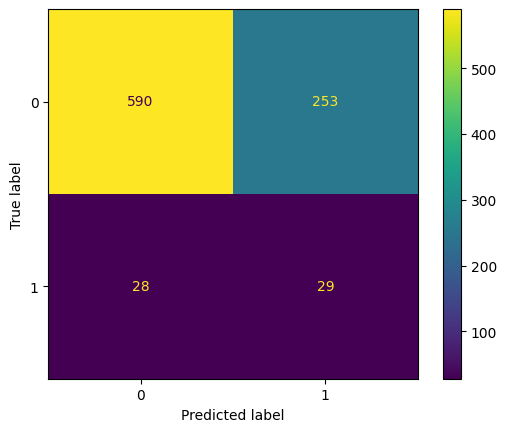

In [7]:
excl_other_model = train_and_evaluate_setfit_model(
    gold_standard_annotations_train,
    gold_standard_annotations_test,
    gold_standard_comments_train,
    gold_standard_comments_test,
    "excl_other"
)

#### Ref-persona

/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Appl

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 16
  Num epochs = 4
  Total optimization steps = 200


Epoch,Training Loss,Validation Loss,Rate
1,No log,0.240300,0.000017
2,No log,0.304900,0.000011
3,No log,0.303000,0.000006
4,No log,0.305400,0.000000


  0%|          | 0/1113 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 50.


accuracy: 0.7325842696629213
f1-score: 0.8143525741029642


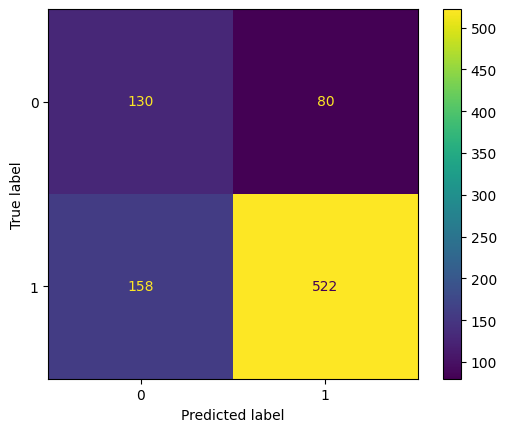

In [8]:
ref_persona_model = train_and_evaluate_setfit_model(
    gold_standard_annotations_train,
    gold_standard_annotations_test,
    gold_standard_comments_train,
    gold_standard_comments_test,
    "ref_persona"
)

### Sentiment

/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Appl

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 920
  Batch size = 16
  Num epochs = 4
  Total optimization steps = 232


Epoch,Training Loss,Validation Loss,Rate
1,No log,0.187100,0.000017
2,No log,0.195400,0.000011
3,No log,0.196400,0.000006
4,No log,0.199900,0.000000


  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 58.


accuracy: 0.8013157894736842
f1-score: 0.8013157894736842


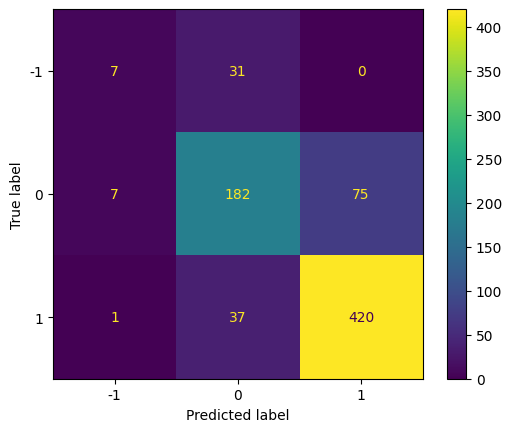

In [9]:
sentiment_overall_model = train_and_evaluate_setfit_model(
    gold_standard_annotations_train,
    gold_standard_annotations_test,
    gold_standard_comments_train,
    gold_standard_comments_test,
    "sentiment_overall"
)

### Cognitive Response

#### Ambiguity

/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Appl

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 16
  Num epochs = 4
  Total optimization steps = 200


Epoch,Training Loss,Validation Loss,Rate
1,No log,0.308300,0.000017
2,No log,0.353500,0.000011
3,No log,0.357600,0.000006
4,No log,0.357100,0.000000


  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 50.


accuracy: 0.6552631578947369
f1-score: 0.3609756097560975


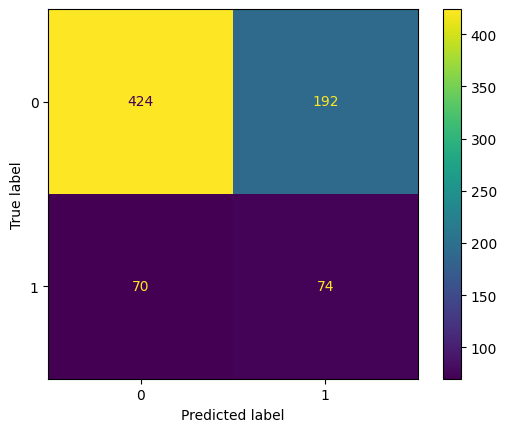

In [10]:
ambiguity_model = train_and_evaluate_setfit_model(
    gold_standard_annotations_train,
    gold_standard_annotations_test,
    gold_standard_comments_train,
    gold_standard_comments_test,
    "ambiguity"
)

#### Comprehension

/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Appl

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 16
  Num epochs = 4
  Total optimization steps = 200


Epoch,Training Loss,Validation Loss,Rate
1,No log,0.287200,0.000017
2,No log,0.342200,0.000011
3,No log,0.347800,0.000006
4,No log,0.351500,0.000000


  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 50.


accuracy: 0.5723684210526315
f1-score: 0.36647173489278756


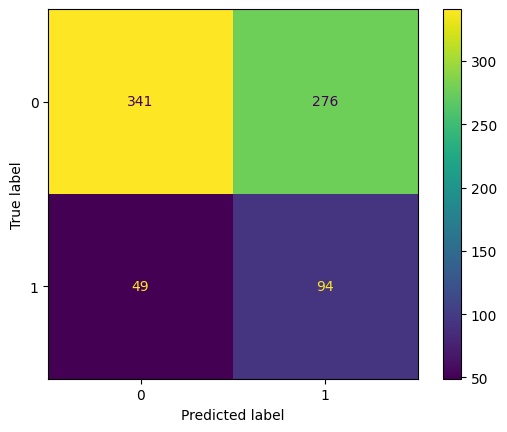

In [11]:
comprehension_model = train_and_evaluate_setfit_model(
    gold_standard_annotations_train,
    gold_standard_annotations_test,
    gold_standard_comments_train,
    gold_standard_comments_test,
    "comprehension"
)

#### Memory-relate

/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Appl

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 560
  Batch size = 16
  Num epochs = 4
  Total optimization steps = 140


Epoch,Training Loss,Validation Loss,Rate
1,No log,0.247500,0.000017
2,No log,0.305100,0.000011
3,No log,0.311100,0.000006
4,No log,0.314700,0.000000


  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 35.


accuracy: 0.8881578947368421
f1-score: 0.17475728155339804


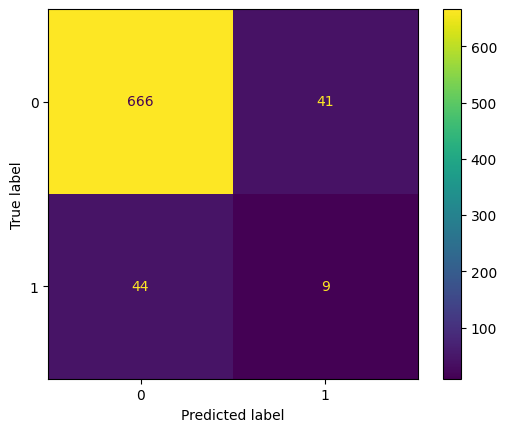

In [12]:
memory_relate_model = train_and_evaluate_setfit_model(
    gold_standard_annotations_train,
    gold_standard_annotations_test,
    gold_standard_comments_train,
    gold_standard_comments_test,
    "memory_relate"
)

#### Self-relate

/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Appl

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 16
  Num epochs = 4
  Total optimization steps = 200


Epoch,Training Loss,Validation Loss,Rate
1,No log,0.271100,0.000017
2,No log,0.289600,0.000011
3,No log,0.293600,0.000006
4,No log,0.292900,0.000000


  0%|          | 0/949 [00:00<?, ?it/s]

  0%|          | 0/949 [00:00<?, ?it/s]

  0%|          | 0/949 [00:00<?, ?it/s]

  0%|          | 0/949 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 50.


accuracy: 0.6297760210803689
f1-score: 0.35103926096997695


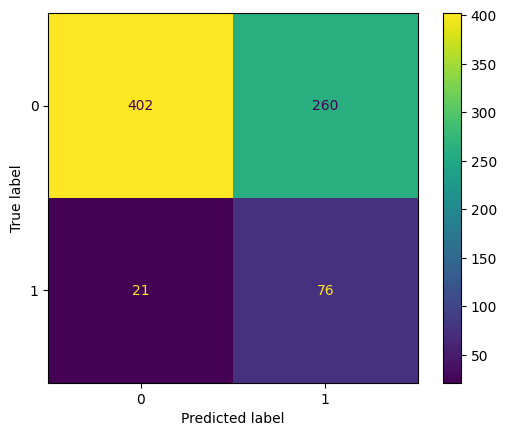

In [13]:
self_relate_model = train_and_evaluate_setfit_model(
    gold_standard_annotations_train,
    gold_standard_annotations_test,
    gold_standard_comments_train,
    gold_standard_comments_test,
    "self_relate"
)

#### Evaluation

/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Appl

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 16
  Num epochs = 4
  Total optimization steps = 200


Epoch,Training Loss,Validation Loss,Rate
1,No log,0.288000,0.000017
2,No log,0.330900,0.000011
3,No log,0.329100,0.000006
4,No log,0.333300,0.000000


  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 50.


accuracy: 0.6526315789473685
f1-score: 0.6937354988399073


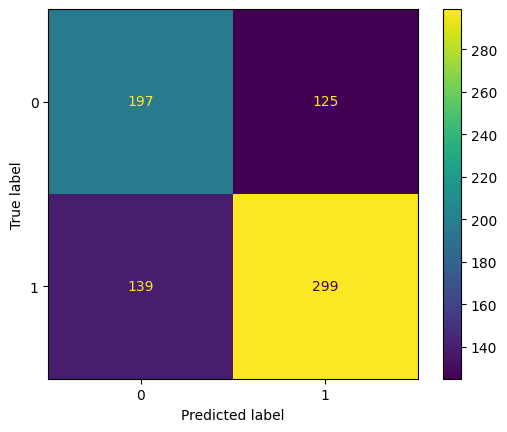

In [14]:
evaluation_model = train_and_evaluate_setfit_model(
    gold_standard_annotations_train,
    gold_standard_annotations_test,
    gold_standard_comments_train,
    gold_standard_comments_test,
    "evaluation"
)

#### Future

/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Appl

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 16
  Num epochs = 4
  Total optimization steps = 200


Epoch,Training Loss,Validation Loss,Rate
1,No log,0.275000,0.000017
2,No log,0.324100,0.000011
3,No log,0.331900,0.000006
4,No log,0.324700,0.000000


  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 50.


accuracy: 0.7355263157894737
f1-score: 0.4937027707808564


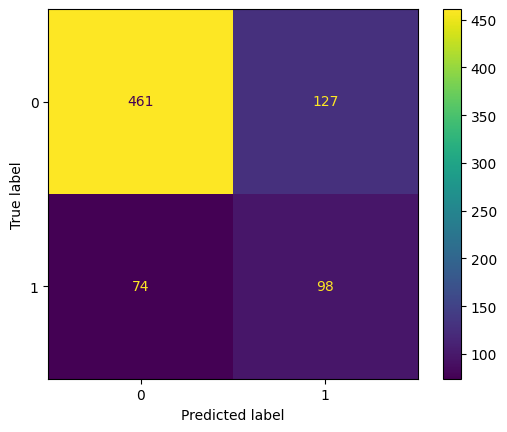

In [15]:
future_model = train_and_evaluate_setfit_model(
    gold_standard_annotations_train,
    gold_standard_annotations_test,
    gold_standard_comments_train,
    gold_standard_comments_test,
    "future"
)

### Affective Response

#### Sympathy-Antipathy

/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Appl

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 16
  Num epochs = 4
  Total optimization steps = 200


Epoch,Training Loss,Validation Loss,Rate
1,No log,0.269300,0.000017
2,No log,0.324600,0.000011
3,No log,0.326600,0.000006
4,No log,0.329100,0.000000


  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 50.


accuracy: 0.6078947368421053
f1-score: 0.6037234042553191


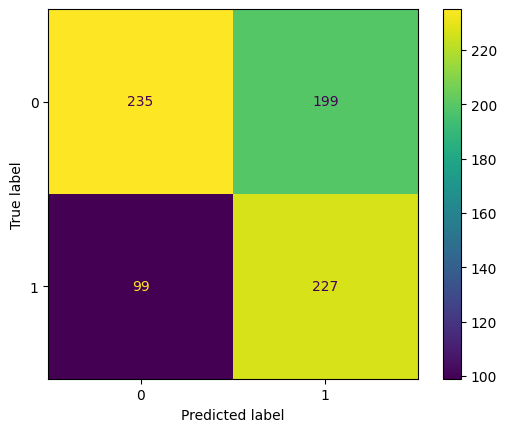

In [16]:
sympathy_antipathy_model = train_and_evaluate_setfit_model(
    gold_standard_annotations_train,
    gold_standard_annotations_test,
    gold_standard_comments_train,
    gold_standard_comments_test,
    "sympathy_antipathy"
)

#### Empathy-Counterempathy

/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Appl

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 16
  Num epochs = 4
  Total optimization steps = 200


Epoch,Training Loss,Validation Loss,Rate
1,No log,0.297100,0.000017
2,No log,0.348200,0.000011
3,No log,0.361400,0.000006
4,No log,0.350300,0.000000


  0%|          | 0/949 [00:00<?, ?it/s]

  0%|          | 0/949 [00:00<?, ?it/s]

  0%|          | 0/949 [00:00<?, ?it/s]

  0%|          | 0/949 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 50.


accuracy: 0.5006587615283268
f1-score: 0.17067833698030635


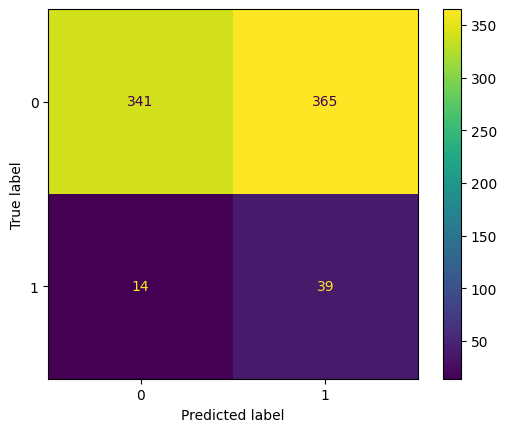

In [17]:
empathy_counterempathy_model = train_and_evaluate_setfit_model(
    gold_standard_annotations_train,
    gold_standard_annotations_test,
    gold_standard_comments_train,
    gold_standard_comments_test,
    "empathy_counterempathy"
)

#### Emotion-release

/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/ma/ma_ma/ma_fvogl/.local/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Appl

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 16
  Num epochs = 4
  Total optimization steps = 200


Epoch,Training Loss,Validation Loss,Rate
1,No log,0.340600,0.000017
2,No log,0.358500,0.000011
3,No log,0.357500,0.000006
4,No log,0.355400,0.000000


  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

Loading best SentenceTransformer model from step 50.


accuracy: 0.5197368421052632
f1-score: 0.17233560090702948


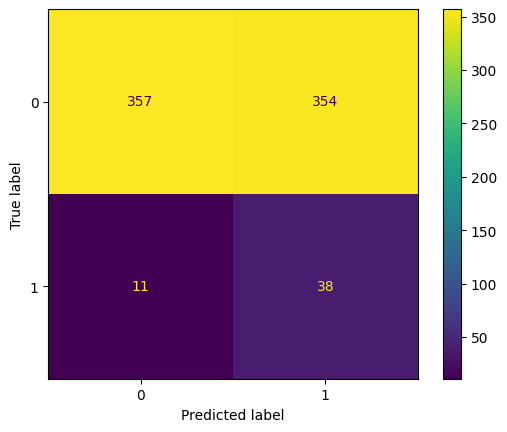

In [18]:
emotion_release_model = train_and_evaluate_setfit_model(
    gold_standard_annotations_train,
    gold_standard_annotations_test,
    gold_standard_comments_train,
    gold_standard_comments_test,
    "emotion_release"
)

## Making Predictions

In [19]:
gold_standard_annotations.head()

,coder_id,excl_other,ref_persona,sentiment_overall,ambiguity,comprehension,memory_relate,self_relate,evaluation,future,sympathy_antipathy,empathy_counterempathy,emotion_release
rowid,,,,,,,,,,,,,
201,AM,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
202,AM,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
203,AM,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,AM,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,AM,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
excl_other_preds = excl_other_model.predict(all_comments["comment"])
ref_persona_preds = ref_persona_model.predict(all_comments["comment"])
sentiment_overall_preds = sentiment_overall_model.predict(all_comments["comment"])
ambiguity_preds = ambiguity_model.predict(all_comments["comment"])
comprehension_preds = comprehension_model.predict(all_comments["comment"])
memory_relate_preds = memory_relate_model.predict(all_comments["comment"])
self_relate_preds = self_relate_model.predict(all_comments["comment"])
evaluation_preds = evaluation_model.predict(all_comments["comment"])
future_preds = future_model.predict(all_comments["comment"])
sympathy_antipathy_preds = sympathy_antipathy_model.predict(all_comments["comment"])
empathy_counterempathy_preds = empathy_counterempathy_model.predict(all_comments["comment"])
emotion_release_preds = emotion_release_model.predict(all_comments["comment"])

In [21]:
predictions = pd.DataFrame({
    "comment_id": all_comments["comment_id"],
    "excl_other": excl_other_preds,
    "ref_persona": ref_persona_preds,
    "sentiment_overall": sentiment_overall_preds,
    "ambiguity": ambiguity_preds,
    "comprehension": comprehension_preds,
    "memory_relate": memory_relate_preds,
    "self_relate": self_relate_preds,
    "evaluation": evaluation_preds,
    "future": future_preds,
    "sympathy_antipathy": sympathy_antipathy_preds,
    "empathy_counterempathy": empathy_counterempathy_preds,
    "emotion_release": emotion_release_preds
})

predictions.to_csv("data/setfit_predictions.csv", index=False)